In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sqlite3
import json
import statsmodels.api as sm
from lmfit.model import Model, save_modelresult, load_modelresult
from lmfit.models import LinearModel
from lmfit import minimize, Parameters, create_params
import matplotlib as mpl

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [3]:
def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

def melt_fit(x, a, b, c, d, f, g):
    # a: slope of the unfolded state
    # b: y-intercept of the unfolded state
    # c: slope of the folded state
    # d: y-intercept of the folded state
    # f: energy of the transition state
    # g: temperature of the transition state
    
    temp = 1 / x

    R = 0.001987
    R = 0.0083145
    K1 = np.exp((f/R)*(1/(g+273.15) - 1/(temp)))
    Q1 = 1 + K1
    fracu = 1 / Q1
    fracf = K1 / Q1
    basef = a * x + b
    baseu = c * x + d

    final = np.log(fracu) * baseu + np.log(fracf) * basef
    final = fracu * baseu + fracf * basef
    return final

def fit_meltcurve(x, y, kadd_params = None):
    # Make sure x is sorted

    # Guess top baseline
    model = LinearModel()
    params = model.guess(y.iloc[:3], x = x.iloc[:3])
    top_fit = model.fit(y.iloc[:3], params, x = x.iloc[:3])
    init_m_top = top_fit.params['slope'].value
    init_b_top = top_fit.params['intercept'].value

    # Guess bottom baseline
    params = model.guess(y.iloc[-3:], x = x.iloc[-3:])
    bot_fit = model.fit(y.iloc[-3:], params, x = x.iloc[-3:])
    init_m_bot = bot_fit.params['slope'].value
    init_b_bot = bot_fit.params['intercept'].value
    
    init_m = (init_m_top + init_m_bot) / 2

    # Actual fit
    melt_model = Model(melt_fit)
    melt_params = melt_model.make_params(a = init_m_bot, b = init_b_bot, c = init_m_top, d = init_b_top, f = -500, g = 40)
    melt_params['g'].vary = True
    # bottom intercept needs to be lower than upper intercept
    melt_params['b'].max = init_b_top

    if kadd_params is not None:
        # lock to kadd_params
        kadd_slope, kadd_intercept = kadd_params
        melt_params['c'].value = kadd_slope
        melt_params['d'].value = kadd_intercept
        melt_params['c'].vary = False
        melt_params['d'].vary = False
    
    melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)

    return melt_result

# calculate smoothed best-fit values based on melt_result
def calc_smoothed_best_fit(melt_result):
    x = melt_result.userkws['x']
    x_data = np.linspace(min(x), max(x), 1000)
    y_data = melt_result.eval(x = x_data)
    return x_data, y_data

def eval_extrapolate(x, slope, slope_err, intercept, intercept_err):
    """
    Evaluate a linear function y = mx + b at a given x with propagated uncertainty.
    
    Parameters:
    x (float): The x-value at which to evaluate the function.
    slope (float): The slope (m) of the linear function.
    slope_err (float): The uncertainty in the slope.
    intercept (float): The intercept (b) of the linear function.
    intercept_err (float): The uncertainty in the intercept.
    
    Returns:
    tuple: (y, uncertainty_y), where y is the evaluated value and uncertainty_y is the propagated uncertainty.
    """
    y = slope * x + intercept
    uncertainty_y = np.sqrt((x * slope_err) ** 2 + intercept_err ** 2)
    
    return y, uncertainty_y

def fit_melting_curve(fits, construct, site, kadd_params = None, agg_mean = False):
    """
    Fit a melting curve for a given construct and site.

    Parameters:
        fits (pd.DataFrame): DataFrame containing the fit data.
        construct (str): The construct name to filter the data.
        site (int): The site number to filter the data.
        kadd_params (tuple): Tuple containing the slope and intercept of the kadd curve.

    Returns:
        tuple: A tuple containing:
            - fits_filt (pd.DataFrame): Filtered DataFrame for the given construct and site.
            - melt_result (lmfit.model.ModelResult): Result of the melting curve fit.
            - smooth_x (np.ndarray): Smoothed x-values for the fitted curve.
            - smooth_y (np.ndarray): Smoothed y-values for the fitted curve.
            - lnkobs_20C (float): Natural log of kobs at 20°C.
            - lnkobs_20C_err (float): Uncertainty in the natural log of kobs at 20°C.
            - lnkadd (float): Natural log of kadd at 20°C.
            - lnkadd_err (float): Uncertainty in the natural log of kadd at 20°C.
            - kadd_curve_x (np.ndarray): x-values for the kadd curve.
            - kadd_curve_y (np.ndarray): y-values for the kadd curve.
    
    """
    fits_filt = fits[(fits['disp_name'] == construct) & (fits['site'] == site)].copy()
    fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
    fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']

    if agg_mean:
        fits_filt = fits_filt.groupby('temperature').mean().reset_index()

    melt_result = fit_meltcurve(fits_filt['inv_temp'], fits_filt['log_kobs'], kadd_params)
    smooth_x, smooth_y = calc_smoothed_best_fit(melt_result)

    # calculate lnkobs at 20C
    lnkobs_20C = melt_result.eval(x = 1 / (273.15 + 20))
    lnkobs_20C_err = melt_result.eval_uncertainty(x = 1 / (273.15 + 20))

    # draw upper baseline
    slope = melt_result.params['c'].value
    slope_err = melt_result.params['c'].stderr
    intercept = melt_result.params['d'].value
    intercept_err = melt_result.params['d'].stderr
    kadd_curve_x = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 1000)
    kadd_curve_y = slope * kadd_curve_x + intercept

    # calculate lnkadd at 20C
    lnkadd, lnkadd_err = eval_extrapolate(1 / (273.15 + 20), slope, slope_err, intercept, intercept_err)
    
    return fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y, 

In [4]:
# Load data

global_fits = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/06_aggfit_ntp_adduction/reference/EKC.01.061.analyze_fit_distributions/global_refit_results.db'

conn = sqlite3.connect(global_fits)
query = 'SELECT * FROM global_fits'
fits = pd.read_sql_query(query, conn)
fits

# get experimental info
main_db  = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/06_aggfit_ntp_adduction/reference/EKC.01.060.developing_DB_input/new.db'
conn = sqlite3.connect(main_db)
query = """
    SELECT pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM reaction_groups rg
    JOIN constructs c ON pr.construct_id = c.id
    LEFT JOIN probing_reactions pr ON rg.rxn_id = pr.id
    WHERE pr.RT = 'MRT'
    GROUP BY rg.rg_id
"""
exp_info = pd.read_sql_query(query, conn)
fits['rg_id'] = fits['rg_id'].astype(int)
fits = fits.merge(exp_info, left_on='rg_id', right_on='rg_id', how='left')

# drop duplicates
fits = fits.drop_duplicates()
# filter fits to under 85C
fits = fits[fits['temperature'] < 85]
fits

,site,log_kappa,log_kdeg,log_fmod_0,r2,stderr_log_kappa,stderr_log_kdeg,stderr_log_fmod_0,rg_id,temperature,disp_name,buffer_id
0,1,-6.816452,-8.121080,-11.629118,0.953716,0.110213,0.0,9.961597,7,25,4U_a8c,1
1,2,-5.267578,-8.121080,-6.841065,0.917437,0.150436,0.0,0.531036,7,25,4U_a8c,1
2,3,-4.680462,-8.121080,-5.801307,0.938039,0.129168,0.0,0.288928,7,25,4U_a8c,1
3,5,-7.617252,-8.121080,-7.020689,0.684740,0.339345,0.0,0.137336,7,25,4U_a8c,1
4,6,-6.082823,-8.121080,-6.875103,0.920598,0.147028,0.0,0.238243,7,25,4U_a8c,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6801,45,-3.500979,-3.623204,-6.523956,0.990812,0.043757,0.0,0.691059,118,70,hiv_c30u,4
6802,61,-4.128334,-3.623204,-8.138642,0.984694,0.056234,0.0,2.414572,118,70,hiv_c30u,4
6803,62,-4.218293,-3.623204,-8.518886,0.995414,0.030594,0.0,1.758088,118,70,hiv_c30u,4
6804,63,-6.942364,-3.623204,-6.424360,0.822663,0.207726,0.0,0.097666,118,70,hiv_c30u,4


### Scatterplots of $k_{obs}$ and $k_{obs}/k_{deg}$

In [5]:
site = 18

def scatterplot_lnk(fits, site, lnk_toplot = 'log_kobs'):
    fits_filt = fits[(fits['disp_name'] == '4U_wt') & (fits['site'] == site)].copy()
    fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
    fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']

    fits_filt2 = fits[(fits['disp_name'] == '4U_a8c') & (fits['site'] == site)].copy()
    fits_filt2.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt2['temperature'])
    fits_filt2.loc[:, 'log_kobs'] = fits_filt2['log_kappa'] + fits_filt2['log_kdeg']

    # [PLOT] ln_kobs vs 1/T
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex = True, sharey = True)
    formatter = FuncFormatter(thousands)
    color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}

    # draw vertical line at 20C
    axs[0].axvline(1/(273.15 + 20), color='gray', linestyle='--')
    axs[1].axvline(1/(273.15 + 20), color='gray', linestyle='--')

    sns.scatterplot(data=fits_filt, x='inv_temp', y=lnk_toplot, color=color_dict['4U_wt'], ax=axs[0])
    axs[0].xaxis.set_major_formatter(formatter)
    axs[0].set_ylabel(r'$\ln(k_{obs})$')
    axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
    axs[0].annotate(f'WT {site}', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

    sns.scatterplot(data=fits_filt2, x='inv_temp', y=lnk_toplot, color=color_dict['4U_a8c'], ax=axs[1])
    axs[1].xaxis.set_major_formatter(formatter)
    axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
    axs[1].annotate(f'A8C {site}', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

    plt.tight_layout()
    #plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/18A_lnkobs_nofit.pdf')
    plt.show()

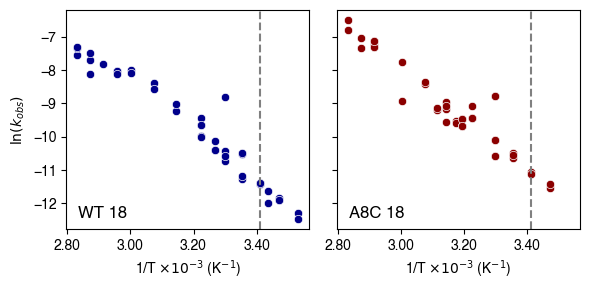

In [6]:
scatterplot_lnk(fits, site, 'log_kobs')

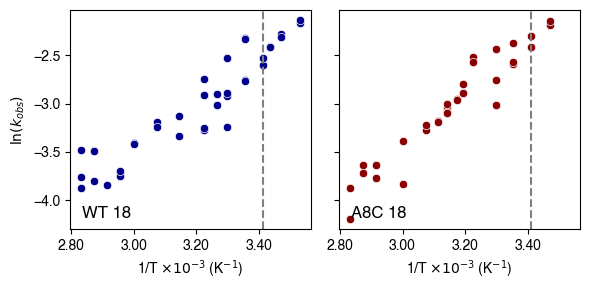

In [7]:
scatterplot_lnk(fits, site, 'log_kappa')

### Calculate end points over temps

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_56622/1495879488.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(frameon=False)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


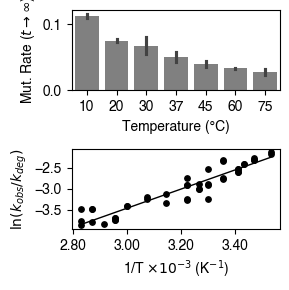

In [13]:
def calc_endpt(log_kappa, log_kdeg, log_fmod_0):
    kappa = np.exp(log_kappa)
    kdeg = np.exp(log_kdeg)
    fmod0 = np.exp(log_fmod_0)
    return 1 - np.exp(-kappa) + fmod0
    
fits_filt = fits[(fits['disp_name'] == '4U_wt') & (fits['site'] == 18)].copy()
fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']
fits_filt['calc_endpt'] = calc_endpt(fits_filt['log_kappa'], fits_filt['log_kdeg'], fits_filt['log_fmod_0'])

# select temps 10, 20, 37, 45, 52, 75
fits_filt_select = fits_filt[fits_filt['temperature'].isin([10, 20, 30, 37, 45, 60, 75])]

fig, axs = plt.subplots(2, 1, figsize=(3, 3))
sns.barplot(data = fits_filt_select, x = 'temperature', y = 'calc_endpt', color = 'gray', ax = axs[0])
axs[0].set_ylabel(r'Mut. Rate ($t \rightarrow \infty$)')
axs[0].set_xlabel('Temperature (°C)')



formatter = FuncFormatter(thousands)
axs[1].scatter(x=fits_filt['inv_temp'], y=fits_filt['log_kappa'], color='black', s=15)
# linear fit
m, b = np.polyfit(fits_filt['inv_temp'], fits_filt['log_kappa'], 1)
x_range = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 2)
kobs_bestfit = m * x_range + b
axs[1].plot(x_range, kobs_bestfit, color='black', linewidth=1)

axs[1].legend(frameon=False)
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_ylabel(r'$\ln(k_{obs} / k_{deg})$')
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
plt.tight_layout()

plt.tight_layout()
plt.savefig('18A_endpt.pdf')
plt.show()

### Plot ln(kobs) with linear fit (18A)

In [ ]:
import lmfit
all_fit_params = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/05_nmr_ntp_adduction/01.047.NMR_NTP_adduction_kinetics/data/peak_analysis/all_data_fitparams.csv'
nmr_ntp = pd.read_csv(all_fit_params)
peak8 = nmr_ntp[nmr_ntp['peak'] == 'peak8']
peak8_atp = peak8[peak8['ntp'] == 'ATP']

# linear fit
model = lmfit.models.LinearModel()
params = model.guess(peak8_atp['lnkadd'], x=peak8_atp['1/T'])
atp_result = model.fit(peak8_atp['lnkadd'], params, x=peak8_atp['1/T'])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


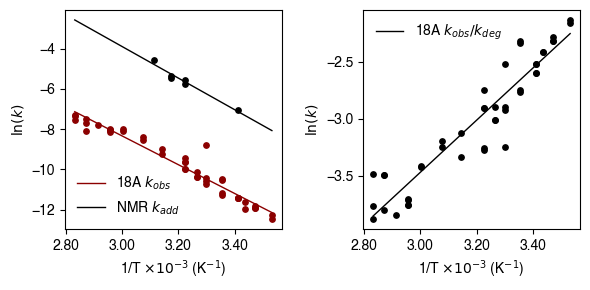

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
formatter = FuncFormatter(thousands)

site = 18
fits_filt = fits[(fits['disp_name'] == '4U_wt') & (fits['site'] == site)].copy()
fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']
# linear fit
m, b = np.polyfit(fits_filt['inv_temp'], fits_filt['log_kobs'], 1)
x_range = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 2)
kobs_bestfit = m * x_range + b

#agg_4U = 10.3381005478143  + (-6136.74255936775 * x_range)
#agg_hiv = 10.0063275375075  + (-6138.14671310593 * x_range)

#axs[0].plot(x_range, agg_4U, color='darkblue', linewidth=1, label=r'4U $k_{add}$')
#axs[0].plot(x_range, agg_hiv, color='darkgreen', linewidth=1, label=r'HIV $k_{add}$')

axs[0].scatter(x=fits_filt['inv_temp'], y=fits_filt['log_kobs'], color='darkred', s=15)
axs[0].plot(x_range, kobs_bestfit, color='darkred', linewidth=1, label=r'18A $k_{obs}$')

axs[0].scatter(peak8_atp['1/T'], peak8_atp['lnkadd'], color='black', linewidth=1, s = 15)
axs[0].plot(x_range, atp_result.eval(x=x_range), color='black', linewidth=1, label=r'NMR $k_{add}$')

axs[0].legend(frameon=False, loc='lower left')
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$\ln(k)$')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')

formatter = FuncFormatter(thousands)
axs[1].scatter(x=fits_filt['inv_temp'], y=fits_filt['log_kappa'], color='black', s=15)
# linear fit
m, b = np.polyfit(fits_filt['inv_temp'], fits_filt['log_kappa'], 1)
kobs_bestfit = m * x_range + b
axs[1].plot(x_range, kobs_bestfit, color='black', linewidth=1, label=r'18A $k_{obs} / k_{deg}$')

axs[1].legend(frameon=False)
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_ylabel(r'$\ln(k)$')
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
plt.tight_layout()
plt.savefig('18A_lnk_fits.pdf')
plt.show()

In [ ]:
import lmfit
all_fit_params = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/05_nmr_ntp_adduction/01.047.NMR_NTP_adduction_kinetics/data/peak_analysis/all_data_fitparams.csv'
nmr_ntp = pd.read_csv(all_fit_params)
peak8 = nmr_ntp[nmr_ntp['peak'] == 'peak8']
peak8_gtp = peak8[peak8['ntp'] == 'GTP']

# linear fit
model = lmfit.models.LinearModel()
gtp_result = model.fit(peak8_gtp['lnkadd'], params, x=peak8_gtp['1/T'])
lnkadd_gtp20 = gtp_result.eval(x = 1 / (298.15))
print(f'lnkadd_gtp20: {lnkadd_gtp20}')

lnkadd_gtp20: -6.272974102461831


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


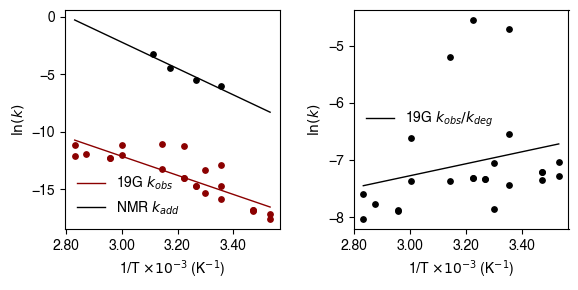

In [ ]:
site = 19
fits_filt = fits[(fits['disp_name'] == '4U_wt') & (fits['site'] == site)].copy()
fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']


fig, axs = plt.subplots(1, 2, figsize=(6, 3))
formatter = FuncFormatter(thousands)

axs[0].scatter(x=fits_filt['inv_temp'], y=fits_filt['log_kobs'], color='darkred', s=15)
# linear fit
m, b = np.polyfit(fits_filt['inv_temp'], fits_filt['log_kobs'], 1)
kobs_bestfit = m * x_range + b
axs[0].plot(x_range, kobs_bestfit, color='darkred', linewidth=1, label=r'19G $k_{obs}$')

#axs[0].scatter(x=df_kdeg['inv_temp'], y=df_kdeg['log_kdeg'], color='black', s=15)
#axs[0].plot(x_range, nmr_bestfit, color='black', linewidth=1, label=r'$NMR k_{deg}$ Fit')

axs[0].scatter(peak8_gtp['1/T'], peak8_gtp['lnkadd'], color='black', linewidth=1, s = 15)
axs[0].plot(x_range, gtp_result.eval(x=x_range), color='black', linewidth=1, label=r'NMR $k_{add}$')

axs[0].legend(frameon=False, loc='lower left')
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$\ln(k)$')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')

formatter = FuncFormatter(thousands)
axs[1].scatter(x=fits_filt['inv_temp'], y=fits_filt['log_kappa'], color='black', s=15)
# linear fit
m, b = np.polyfit(fits_filt['inv_temp'], fits_filt['log_kappa'], 1)
kobs_bestfit = m * x_range + b
axs[1].plot(x_range, kobs_bestfit, color='black', linewidth=1, label=r'19G $k_{obs} / k_{deg}$')

axs[1].legend(frameon=False)
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_ylabel(r'$\ln(k)$')
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
plt.tight_layout()
plt.savefig('19G_lnk_fits.pdf')
plt.show()

In [ ]:
import lmfit
all_fit_params = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/05_nmr_ntp_adduction/01.047.NMR_NTP_adduction_kinetics/data/peak_analysis/all_data_fitparams.csv'
nmr_ntp = pd.read_csv(all_fit_params)
peak8 = nmr_ntp[nmr_ntp['peak'] == 'peak8']
peak8_ctp = peak8[peak8['ntp'] == 'CTP']

# linear fit
model = lmfit.models.LinearModel()
ctp_result = model.fit(peak8_ctp['lnkadd'], params, x=peak8_ctp['1/T'])
lnkadd_ctp20 = ctp_result.eval(x = 1 / (298.15))
print(f'lnkadd_ctp20: {lnkadd_ctp20}')

lnkadd_ctp20: -6.981798003237149


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


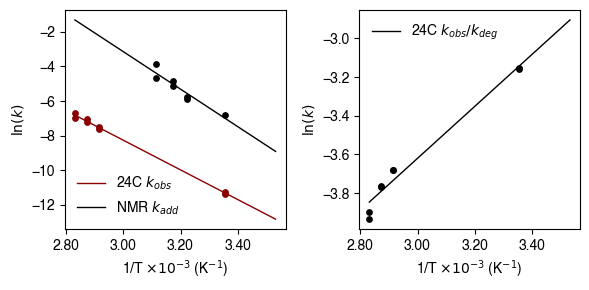

In [ ]:
site = 24
fits_filt = fits[(fits['disp_name'] == 'hiv_wt') & (fits['site'] == site)].copy()
fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
formatter = FuncFormatter(thousands)

axs[0].scatter(x=fits_filt['inv_temp'], y=fits_filt['log_kobs'], color='darkred', s=15)
# linear fit
m, b = np.polyfit(fits_filt['inv_temp'], fits_filt['log_kobs'], 1)
kobs_bestfit = m * x_range + b
axs[0].plot(x_range, kobs_bestfit, color='darkred', linewidth=1, label=r'24C $k_{obs}$')

#axs[0].scatter(x=df_kdeg['inv_temp'], y=df_kdeg['log_kdeg'], color='black', s=15)
#axs[0].plot(x_range, nmr_bestfit, color='black', linewidth=1, label=r'$NMR k_{deg}$ Fit')

axs[0].scatter(peak8_ctp['1/T'], peak8_ctp['lnkadd'], color='black', linewidth=1, s = 15)
axs[0].plot(x_range, ctp_result.eval(x=x_range), color='black', linewidth=1, label=r'NMR $k_{add}$')

axs[0].legend(frameon=False, loc='lower left')
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$\ln(k)$')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')

formatter = FuncFormatter(thousands)
axs[1].scatter(x=fits_filt['inv_temp'], y=fits_filt['log_kappa'], color='black', s=15)
# linear fit
m, b = np.polyfit(fits_filt['inv_temp'], fits_filt['log_kappa'], 1)
kobs_bestfit = m * x_range + b
axs[1].plot(x_range, kobs_bestfit, color='black', linewidth=1, label=r'24C $k_{obs} / k_{deg}$')

axs[1].legend(frameon=False)
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_ylabel(r'$\ln(k)$')
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
plt.tight_layout()
plt.savefig('24C_lnk_fits.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


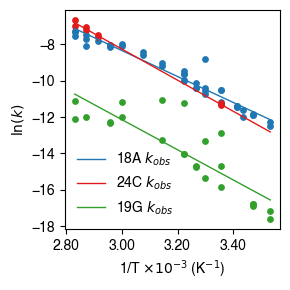

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
formatter = FuncFormatter(thousands)

site = 18
fits_filt = fits[(fits['disp_name'] == '4U_wt') & (fits['site'] == site)].copy()
fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']
# linear fit
m, b = np.polyfit(fits_filt['inv_temp'], fits_filt['log_kobs'], 1)
x_range = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 2)
kobs_bestfit = m * x_range + b

# plot A
ax.scatter(x=fits_filt['inv_temp'], y=fits_filt['log_kobs'], color=sns.color_palette("Paired")[1], s=15)
ax.plot(x_range, kobs_bestfit, color=sns.color_palette("Paired")[1], linewidth=1, label=r'18A $k_{obs}$')


# plot C
site = 24
fits_filt = fits[(fits['disp_name'] == 'hiv_wt') & (fits['site'] == site)].copy()
fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']

ax.scatter(x=fits_filt['inv_temp'], y=fits_filt['log_kobs'], color=sns.color_palette("Paired")[5], s=15)
# linear fit
m, b = np.polyfit(fits_filt['inv_temp'], fits_filt['log_kobs'], 1)
kobs_bestfit = m * x_range + b
ax.plot(x_range, kobs_bestfit, color=sns.color_palette("Paired")[5], linewidth=1, label=r'24C $k_{obs}$')


# plot G
site = 19
fits_filt = fits[(fits['disp_name'] == '4U_wt') & (fits['site'] == site)].copy()
fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']

ax.scatter(x=fits_filt['inv_temp'], y=fits_filt['log_kobs'], color=sns.color_palette("Paired")[3], s=15)
# linear fit
m, b = np.polyfit(fits_filt['inv_temp'], fits_filt['log_kobs'], 1)
kobs_bestfit = m * x_range + b
ax.plot(x_range, kobs_bestfit, color=sns.color_palette("Paired")[3], linewidth=1, label=r'19G $k_{obs}$')


ax.legend(frameon=False, loc='lower left')
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k)$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')

formatter = FuncFormatter(thousands)

plt.tight_layout()
plt.savefig('ACG_lnk_fits.pdf')
plt.show()

In [ ]:
site = 18 # 19G, 18A
fits_filt = fits[(fits['disp_name'] == '4U_wt') & (fits['site'] == site)].copy()
fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']

# select 20 temp
fits_filt_select = fits_filt[fits_filt['temperature'].isin([25])]
fits_filt_select
# get mean log_kobs and error from stderr_log_kappa (sqrt sumsq)
mean_log_kobs = fits_filt_select['log_kobs'].mean()
mean_log_kobs_err = np.sqrt(np.sum(fits_filt_select['stderr_log_kappa']**2)) / len(fits_filt_select)
mean_log_kobs, mean_log_kobs_err

(np.float64(-10.8607672364958), np.float64(0.01634215563167497))

In [ ]:
# get experimental info - abandoned figure below

temp = 20

def plot_tc_fit(temp, rep, label, ax):
    main_db  = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/06_aggfit_ntp_adduction/reference/EKC.01.060.developing_DB_input/new.db'
    conn = sqlite3.connect(main_db)

    query = f"""
        SELECT pr.temperature, c.disp_name, pr.reaction_time, fv.fmod_val, pr.replicate, pr.treated, pr.rg_id
        FROM fmod_vals fv
        JOIN probing_reactions pr ON fv.rxn_id = pr.id
        JOIN constructs c ON pr.construct_id = c.id
        JOIN nucleotides n ON fv.nt_id = n.id
        WHERE pr.RT = 'MRT'
        AND pr.temperature == {temp}
        AND c.disp_name == '4U_wt'
        AND n.site == 18
        AND pr.replicate == {rep}
    """
    fmod_data = pd.read_sql_query(query, conn)
    conn.close()
    fmod_data['reaction_time'] = fmod_data['reaction_time'] * fmod_data['treated']

    rg_id = fmod_data['rg_id'].unique()[0]

    global_fit_results = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/06_aggfit_ntp_adduction/reference/EKC.01.061.analyze_fit_distributions/global_refit_results.db'
    glob_conn = sqlite3.connect(global_fit_results)
    query = f"""
        SELECT *
        FROM global_fits
        WHERE rg_id = {rg_id}
        AND site = 18
    """

    fit_params = pd.read_sql_query(query, glob_conn).iloc[-1, :]

    kappa = np.exp(fit_params['log_kappa'])
    kdeg = np.exp(fit_params['log_kdeg'])
    fmod0 = np.exp(fit_params['log_fmod_0'])

    def nonlin_model(x, kappa, kdeg, fmod0):
        return 1 - np.exp(-kappa * (1 - np.exp(-kdeg * x))) + fmod0

    x = np.linspace(0, 50000, 100)
    y = nonlin_model(x, kappa, kdeg, fmod0)
    ax.scatter(fmod_data['reaction_time'] / 3600., fmod_data['fmod_val'], label = label, color = 'darkred')
    ax.plot(x / 3600., y, color = 'darkred')

    return ax

In [ ]:
from scipy.integrate import solve_ivp

def simulate_fraction_modified(ntp_conc, lnkadd, lnkdeg, label, ax):

    RNACONC = ntp_conc
    DMSCONC = 0.01564

    # Initial conditions
    U0 = RNACONC
    S0 = DMSCONC
    M0 = 0.0
    y0 = [U0, S0, M0]

    # Convert log(k1) and log(k2) to k1 and k2
    k1 = np.exp(lnkadd)
    k2 = np.exp(lnkdeg)

    # Define ODE system
    def system(t, y):
        U, S, M = y
        dUdt = -k1 * U * S
        dSdt = -k1 * U * S - k2 * S
        dMdt = k1 * U * S
        return [dUdt, dSdt, dMdt]

    # Add 0 to the beginning if needed
    t = np.linspace(0, 50000, 1001)

    # Simulate the system
    sol = solve_ivp(system, [t[0], t[-1]], y0, t_eval=t, vectorized=True)

    U, S, M = sol.y
    frac_modified = M / RNACONC

    # Plot
    ax.plot(sol.t / 3600., frac_modified, label=label)
    ax.set_xlabel('Time (hr)')
    ax.set_ylabel('Fraction Modified')

    return ax



In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
lnkdeg20 = -8.557912048298853
lnkadd_atp20 = -6.676441506770448
simulate_fraction_modified(1e-6, lnkadd_atp20, lnkdeg20, 'NMR ATP', ax)

plot_tc_fit(20, 1, 'DMS 18A', ax)

# set xlim 10000
#ax.set_xlim(0, 30000)

plt.tight_layout()
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('18A_tc_fit.pdf')

In [ ]:
# lnkadd_atp20: -6.676441506770448
# lnkadd_ctp20: -6.9817980031149816
# lnkadd_gtp20: -6.272974102386847
# lnkdeg at 20°C: -8.557912048298853

from scipy.integrate import solve_ivp

def simulate_fraction_modified(ntp_conc, lnkadd, lnkdeg, label, ax):

    RNACONC = ntp_conc
    DMSCONC = 0.01564

    # Initial conditions
    U0 = RNACONC
    S0 = DMSCONC
    M0 = 0.0
    y0 = [U0, S0, M0]

    # Convert log(k1) and log(k2) to k1 and k2
    k1 = np.exp(lnkadd)
    k2 = np.exp(lnkdeg)

    # Define ODE system
    def system(t, y):
        U, S, M = y
        dUdt = -k1 * U * S
        dSdt = -k1 * U * S - k2 * S
        dMdt = k1 * U * S
        return [dUdt, dSdt, dMdt]

    # Add 0 to the beginning if needed
    t = np.linspace(0, 20000, 1001)

    # Simulate the system
    sol = solve_ivp(system, [t[0], t[-1]], y0, t_eval=t, vectorized=True)

    U, S, M = sol.y
    frac_modified = M / RNACONC

    # Plot
    ax.plot(sol.t, frac_modified, label=label)
    ax.set_xlabel('Time')
    ax.set_ylabel('Fraction Modified')

    return ax

In [ ]:
lnkadd_atp20 = -6.676441506770448
lnkadd_ctp20 = -6.9817980031149816
lnkadd_gtp20 = -6.272974102386847
lnkdeg20 =  -8.557912048298853

In [ ]:
# Create simulated time-course data
fig, ax = plt.subplots(figsize=(3, 3))
simulate_fraction_modified(1e-6, lnkadd_atp20, lnkdeg20, 'ATP', ax)

x = np.linspace(0, fmod_data['reaction_time'].max(), 100)
y = nonlin_model(x, kappa, kdeg, fmod0)
plt.scatter(fmod_data['reaction_time'], fmod_data['fmod_val'], label = 'data')
plt.plot(x, y, label = 'fit')

plt.legend(frameon = False)